# Difference between gridded field (GRIB) and scattered observations (BUFR)

<img src="http://pandas.pydata.org/_static/pandas_logo.png" width=200> 
In this example we will load a gridded model field in GRIB format and a set of observation data in BUFR format. We will then use Metview to examine the data, and compute and plot their differences. Then we will export the set of differences into a pandas dataframe for further inspection.

In [1]:
import metview as mv

In [2]:
use_mars = False # if False, then read data from disk

Metview retrieves/reads GRIB data into its [Fieldset](https://confluence.ecmwf.int/display/METV/Fieldset+Functions) class.

In [3]:
if use_mars:
    t2m_grib = mv.retrieve(type='fc', date=-5, time=12, step=48, levtype='sfc', param='2t', grid='O160', gaussian='reduced')
else:
    t2m_grib = mv.read('t2m_grib.grib')

Define our area of interest and set up some visual styling.

In [4]:
area = [30,-25,72,46] # S,W,N,E

In [5]:
europe = mv.geoview(
    map_area_definition = "corners",
    area                = area,
    coastlines = mv.mcoast(
        map_coastline_land_shade        = "on",
        map_coastline_land_shade_colour = "#eeeeee",
        map_grid_latitude_increment     = 10,
        map_grid_longitude_increment    = 10)
    )

auto_style = mv.mcont(contour_automatic_setting = "ecmwf")

grid_1x1 = mv.mcont(
    contour                          = "off",
    contour_grid_value_plot          = "on",
    contour_grid_value_plot_type     = "marker",
    contour_grid_value_marker_colour = "burgundy",
    grib_scaling_of_retrieved_fields = "off"
    )

Plot the locations of the grid points. We can see the spatial characteristics of the octahedral reduced Gaussian grid.
Plotting is performed through Metview's interface to the [Magics](https://confluence.ecmwf.int/display/MAGP/Magics) library developed at ECMWF. We will first define the view parameters (by default we will get a global map in cylindrical projection).
If we don't set the output destination to be Jupyter, we will get Metview's interactive display window.

In [6]:
mv.setoutput('jupyter')

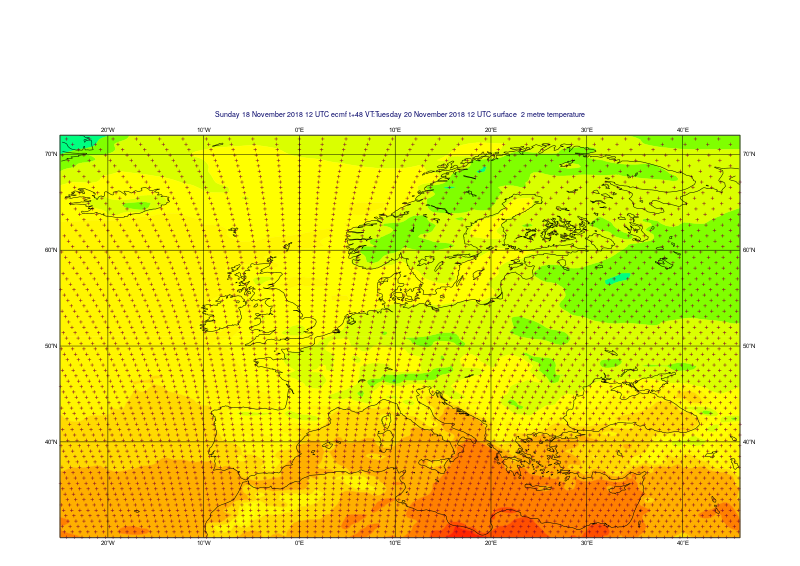

In [7]:
mv.plot(europe, t2m_grib, auto_style, grid_1x1)

Metview retrieves/reads BUFR data into its [Bufr](https://confluence.ecmwf.int/display/METV/Observations+Functions) class.

In [8]:
if use_mars:
    obs_3day = mv.retrieve(
        type   = "ob",
        repres = "bu",
        date   = -3,
        area   = area
        )
else:
    obs_3day = mv.read('./obs_3day.bufr')

Plot the observations on the map.

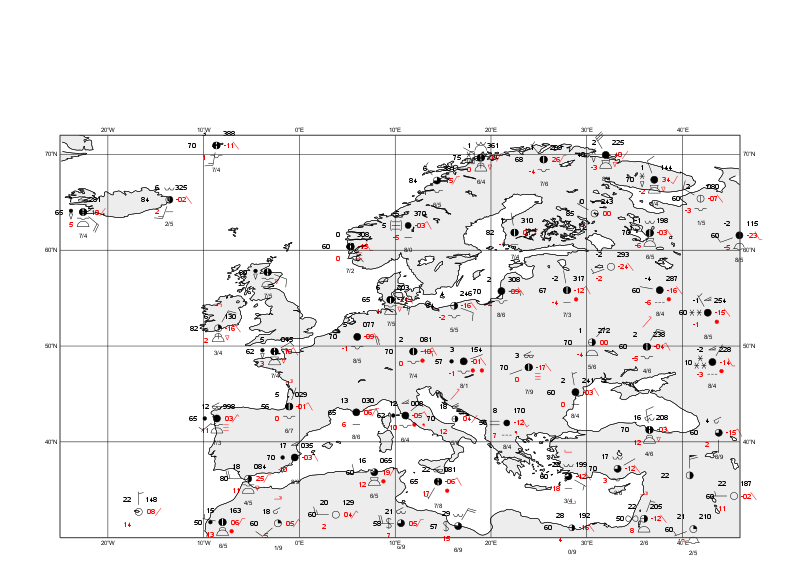

In [9]:
obs_resize = mv.mobs(obs_size = 0.3, obs_ring_size = 0.3, obs_distance_apart = 1.8)
mv.plot(europe, obs_3day, obs_resize)

BUFR can contain a complex arragement of data. Metview has a powerful BUFR examiner [tool](https://confluence.ecmwf.int/display/METV/CodesUI) to inspect the data contents and to see the available keynames. This can be launched with the examine() function. 

In [10]:
mv.examine(obs_3day)

With the information gleaned from that, we can filter the variable we require using the obsfilter() function. This returns a [Geopoints](https://confluence.ecmwf.int/display/METV/Geopoints) object, which has many more [functions](https://confluence.ecmwf.int/display/METV/Geopoints+Functions) available to it. Note: prior to Metview 5.1, only a numeric descriptor could be used to specify the parameter.

In [11]:
t2m_gpt = mv.obsfilter(
    data = obs_3day,
    parameter = 'airTemperatureAt2M',
    output = 'geopoints'
)

Computing the difference between the gridded field and the scattered data is one line of code. Metview will, for each observation point, compute the interpolated value from the field at that location, perform the subtraction and put the result into a new Geopoints object.

In [12]:
diff = t2m_grib - t2m_gpt

We can then use Magics' powerful symbol plotting routine to assign colours and sizes based on the magnitude of the differences.

In [13]:
max_diff = mv.maxvalue(mv.abs(diff))

levels = [max_diff * x for x in [-1, -0.67, -0.33, -0.1, 0.1, 0.33, 0.67, 1]]
 
diff_symb = mv.msymb(
    legend                               = "on",
    symbol_type                          = "marker",
    symbol_table_mode                    = "advanced",
    symbol_outline                       = "on",
    symbol_outline_colour                = "charcoal",
    symbol_advanced_table_selection_type = "list",
    symbol_advanced_table_level_list     = levels,
    symbol_advanced_table_colour_method  = "list",
    symbol_advanced_table_colour_list    = ["blue","sky","rgb(0.82,0.85,1)","white","rgb(0.9,0.8,0.8)","rgb(0.9,0.5,0.5)","red"],
    symbol_advanced_table_height_list    = [0.6,0.5,0.4,0.3,0.3,0.4,0.5,0.6]
)

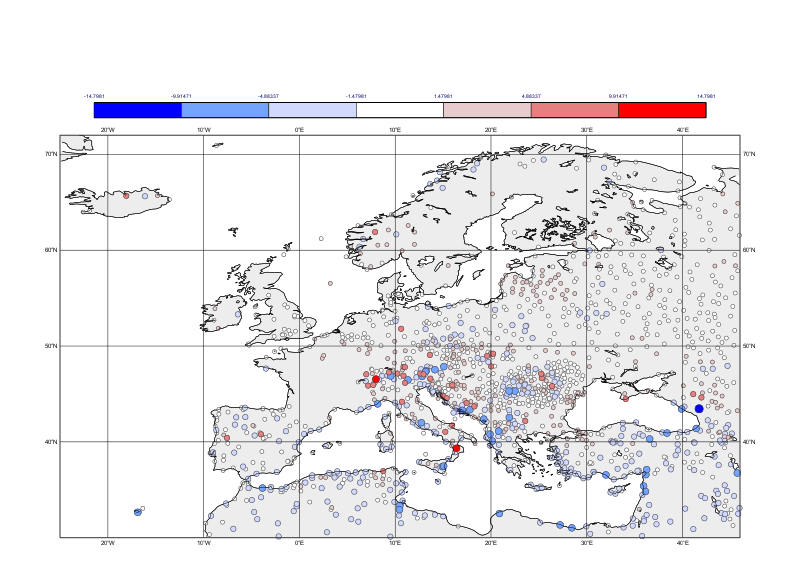

In [14]:
mv.plot(europe, diff, diff_symb)

We can easily convert this to a pandas dataframe for further analysis.

In [15]:
df = diff.to_dataframe()

Print a summary of the whole data set:

In [16]:
df.describe()

,latitude,longitude,value,level
count,1471.000000,1471.000000,1471.000000,1471.0
mean,46.557104,21.160707,-0.201723,0.0
std,8.350950,14.272239,2.417394,0.0
min,30.110000,-22.590000,-10.236664,0.0
25%,40.695000,11.800000,-1.555123,0.0
50%,45.840000,21.950000,-0.174068,0.0
75%,51.550000,31.790000,1.161705,0.0
max,70.930000,45.950000,14.798080,0.0


Or a print a summary of just the actual values:

In [17]:
df.value.describe()

count    1471.000000
mean       -0.201723
std         2.417394
min       -10.236664
25%        -1.555123
50%        -0.174068
75%         1.161705
max        14.798080
Name: value, dtype: float64

Produce a quick scatterplot of latitude vs difference values:

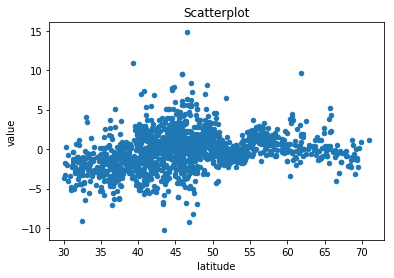

In [19]:
df.plot.scatter(x='latitude', y='value', title='Scatterplot') 

# Additional resources

- [Introductory Metview training course](https://confluence.ecmwf.int/display/METV/Data+analysis+and+visualisation+using+Metview)
- [Metview's Python interface](https://confluence.ecmwf.int/display/METV/Metview%27s+Python+Interface)
- [Function list](https://confluence.ecmwf.int/display/METV/List+of+Operators+and+Functions)
- [Gallery example (field-obs difference)](https://confluence.ecmwf.int/display/METV/Model-Obs%20Difference%20Example)